<a href="https://colab.research.google.com/github/milenacartagenaservi/melanoma/blob/master/modelo_melanoma.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
import os
import random
import pandas as pd
import seaborn as sns

In [15]:
from os import listdir
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

#plotly
!pip install chart_studio
import plotly.express as px
import chart_studio.plotly as py
import plotly.graph_objs as go
from plotly.offline import iplot
import cufflinks
cufflinks.go_offline()
cufflinks.set_config_file(world_readable=True, theme='pearl')

import seaborn as sns
sns.set(style="whitegrid")

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')


# Settings for pretty nice plots
plt.style.use('fivethirtyeight')
plt.show()

Aquí se clona el repositorio

In [2]:
 !git clone --single-branch --branch master https://github.com/milenacartagenaservi/melanoma.git

Cloning into 'melanoma'...
remote: Enumerating objects: 602, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (18/18), done.
remote: Total 602 (delta 8), reused 0 (delta 0), pack-reused 584
Receiving objects: 100% (602/602), 326.68 MiB | 16.75 MiB/s, done.
Resolving deltas: 100% (8/8), done.
Updating files: 100% (603/603), done.


In [36]:
# Leer el dataset de Pandas
train_df = pd.read_csv("/content/melanoma/sampled_train2.csv")
train_df

image_name  patient_id     sex  age_approx  \
0    ISIC_0149568  IP_0962375  female        55.0   
1    ISIC_0152307  IP_6977878    male        35.0   
2    ISIC_0152823  IP_6885799  female        45.0   
3    ISIC_0163639  IP_8019632  female        55.0   
4    ISIC_0188432  IP_0135517  female        50.0   
..            ...         ...     ...         ...   
495  ISIC_9855839  IP_9316325    male        60.0   
496  ISIC_9863642  IP_2172761  female        35.0   
497  ISIC_9910791  IP_6776978  female        60.0   
498  ISIC_9918829  IP_1769689    male        30.0   
499  ISIC_9967383  IP_7887363    male        60.0   

    anatom_site_general_challenge diagnosis benign_malignant  target  
0                 upper extremity  melanoma        malignant       1  
1                           torso   unknown           benign       0  
2                 lower extremity   unknown           benign       0  
3                           torso   unknown           benign       0  
4                 upper extremity  melanoma        malignant       1  
..                            ...       ...              ...     ...  
495                         torso   unknown           benign       0  
496                     head/neck  melanoma        malignant       1  
497                     head/neck  melanoma        malignant       1  
498               upper extremity   unknown           benign       0  
499               upper extremity  melanoma        malignant       1  

[500 rows x 8 columns]

# EDA: Exploratory Data Analysis

En esta sección exploraremos los datos antes de proceder a crear el modelo para conocer su distribución.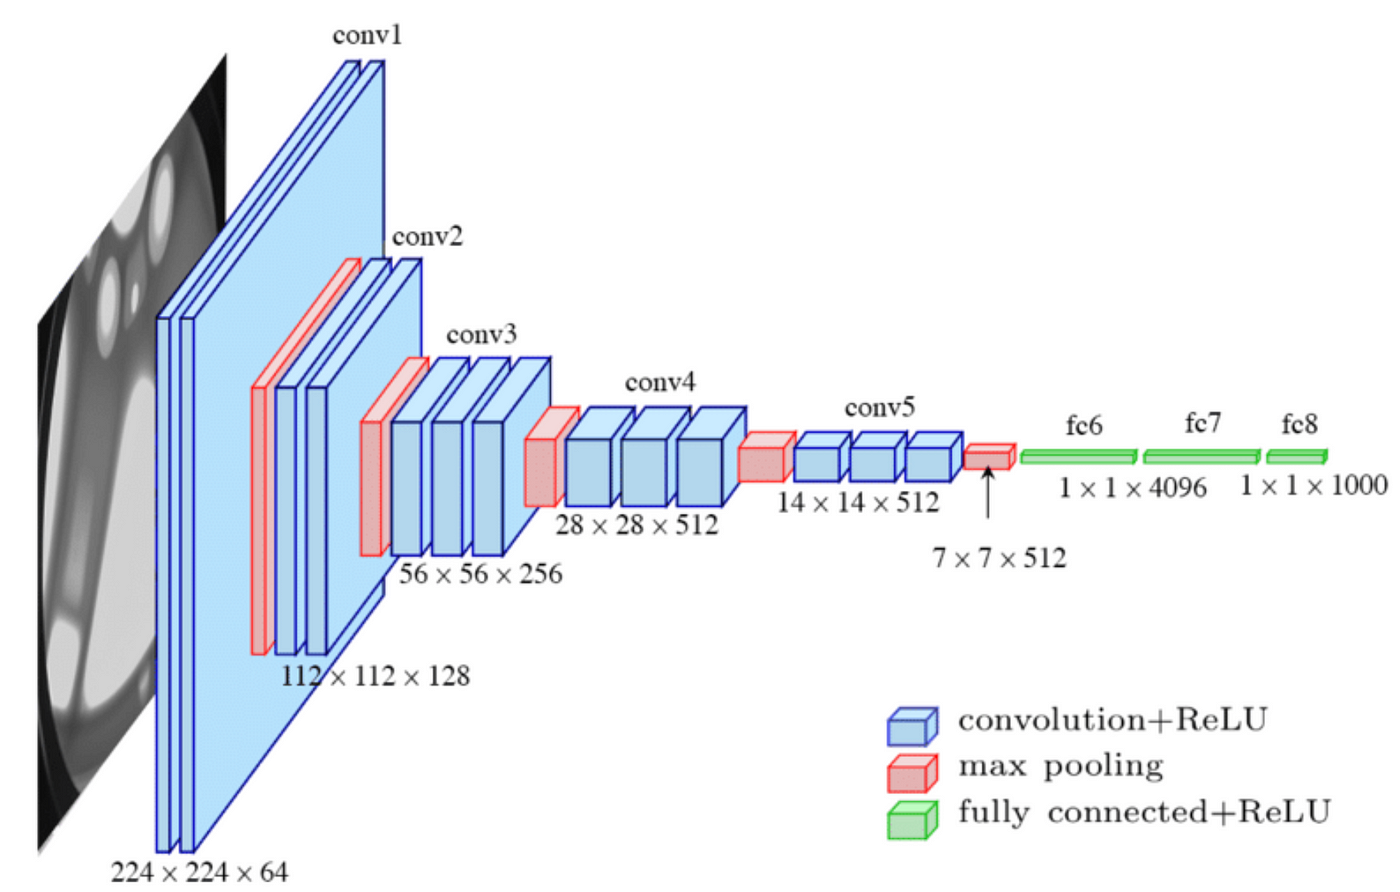

In [37]:
# Null values and Data types
print('Train Set')
print(train_df.info())

Train Set
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   image_name                     500 non-null    object 
 1   patient_id                     500 non-null    object 
 2   sex                            499 non-null    object 
 3   age_approx                     499 non-null    float64
 4   anatom_site_general_challenge  495 non-null    object 
 5   diagnosis                      500 non-null    object 
 6   benign_malignant               500 non-null    object 
 7   target                         500 non-null    int64  
dtypes: float64(1), int64(1), object(6)
memory usage: 31.4+ KB
None


In [7]:
print(f"El número total de ids de pacientes es {train_df['patient_id'].count()}, de los cuales los ids únicos son {train_df['patient_id'].value_counts().shape[0]} ")

El número total de ids de pacientes es 500, de los cuales los ids únicos son 405 


Esto significa que hay pacientes que tienen múltiples registros.

In [8]:
columns = train_df.keys()
columns = list(columns)
print(columns)

['image_name', 'patient_id', 'sex', 'age_approx', 'anatom_site_general_challenge', 'diagnosis', 'benign_malignant', 'target']


In [38]:
# Contemos cuántos datos tenemos en el dataset de entrenamiento:
# 0 es beningno
# 1 es maligno
train_df['target'].value_counts()

target
1    250
0    250
Name: count, dtype: int64

In [9]:
# ¿Cómo es la distribución por sexo?
train_df['sex'].value_counts(normalize=True)

sex
male      0.563126
female    0.436874
Name: proportion, dtype: float64

In [10]:
# Género y target
z=train_df.groupby(['target','sex'])['benign_malignant'].count().to_frame().reset_index()
z.style.background_gradient(cmap='Reds')

Text(0.5, 44.000000000000014, 'benign:0 vs malignant:1')

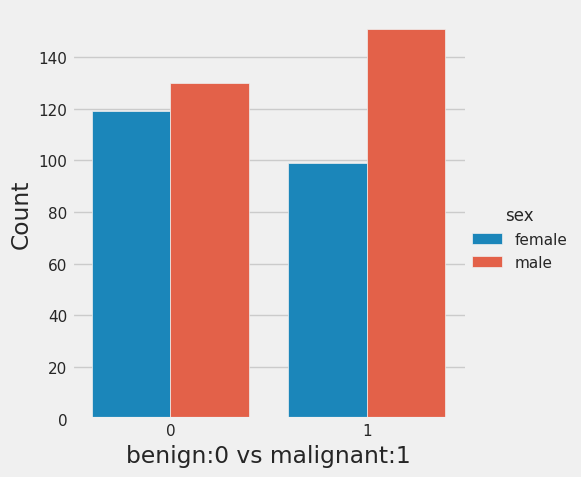

In [16]:
sns.catplot(x='target',y='benign_malignant', hue='sex',data=z,kind='bar')
plt.ylabel('Count')
plt.xlabel('benign:0 vs malignant:1')

In [19]:
# Ubicación del melanoma
train_df['anatom_site_general_challenge'].value_counts(normalize=True).sort_values()

anatom_site_general_challenge
oral/genital       0.008081
palms/soles        0.010101
head/neck          0.088889
upper extremity    0.179798
lower extremity    0.224242
torso              0.488889
Name: proportion, dtype: float64

Text(61.97017708333334, 0.5, 'count of melanoma cases')

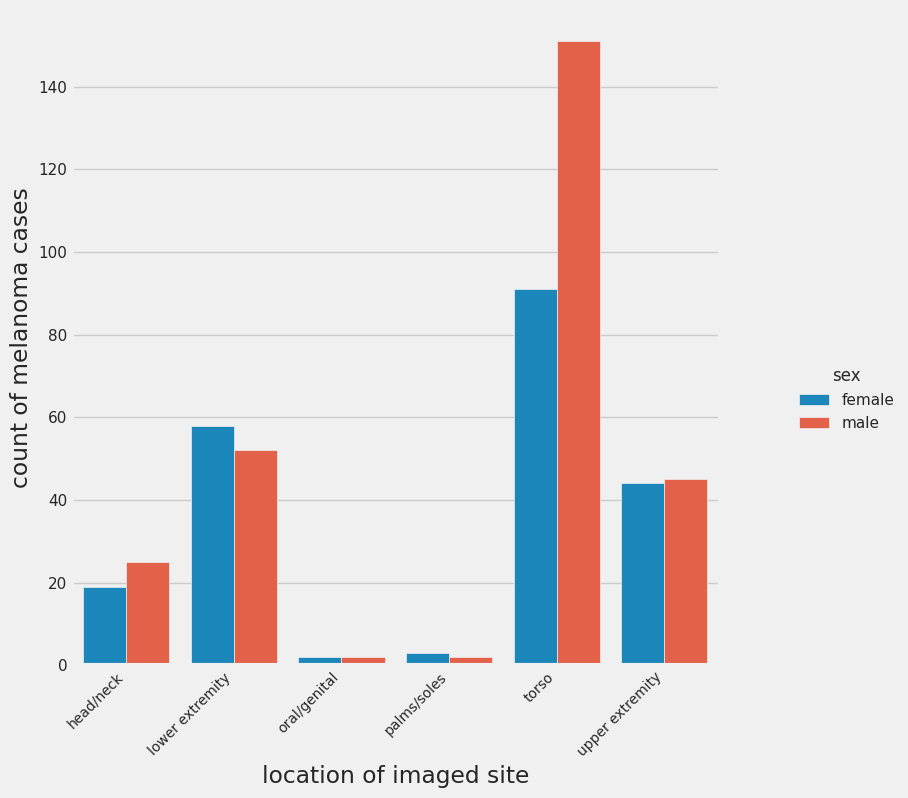

In [22]:
# Ubicación de la imagen por género

z1=train_df.groupby(['sex','anatom_site_general_challenge'])['benign_malignant'].count().to_frame().reset_index()
z1.style.background_gradient(cmap='Reds')
sns.catplot(x='anatom_site_general_challenge',y='benign_malignant', hue='sex',data=z1,kind='bar')
plt.gcf().set_size_inches(10,8)
plt.xlabel('location of imaged site')
plt.xticks(rotation=45,fontsize='10', horizontalalignment='right')
plt.ylabel('count of melanoma cases')

<Axes: ylabel='Frequency'>

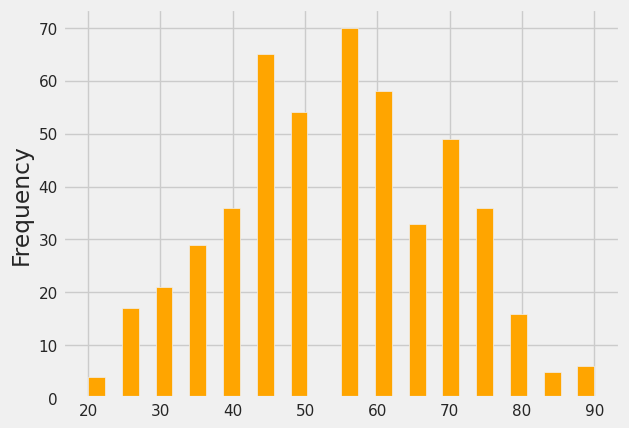

In [26]:
# Distribución de edad de los pacientes
train_df['age_approx'].plot(kind='hist',bins=30,color='orange')

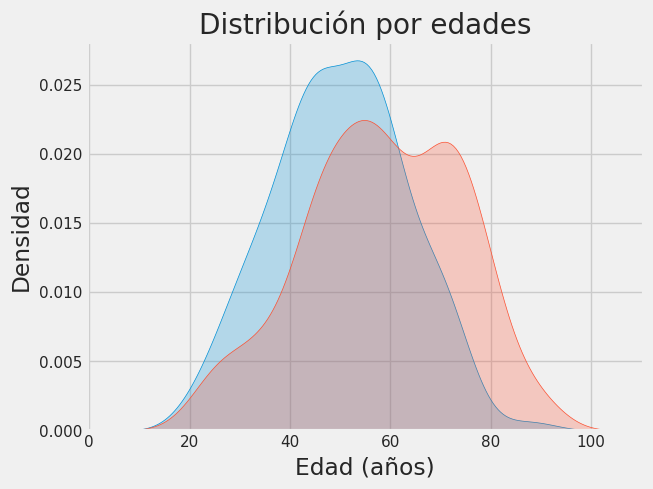

In [28]:
# KDE plot of age that were diagnosed as benign
sns.kdeplot(train_df.loc[train_df['target'] == 0, 'age_approx'], label = 'Benigno',shade=True)

# KDE plot of age that were diagnosed as malignant
sns.kdeplot(train_df.loc[train_df['target'] == 1, 'age_approx'], label = 'Maligno',shade=True)

# Labeling of plot
plt.xlabel('Edad (años)'); plt.ylabel('Densidad'); plt.title('Distribución por edades');


In [29]:
# Distribución del diagnóstico:
train_df['diagnosis'].value_counts()

diagnosis
melanoma    250
unknown     211
nevus        39
Name: count, dtype: int64

Display Random Images


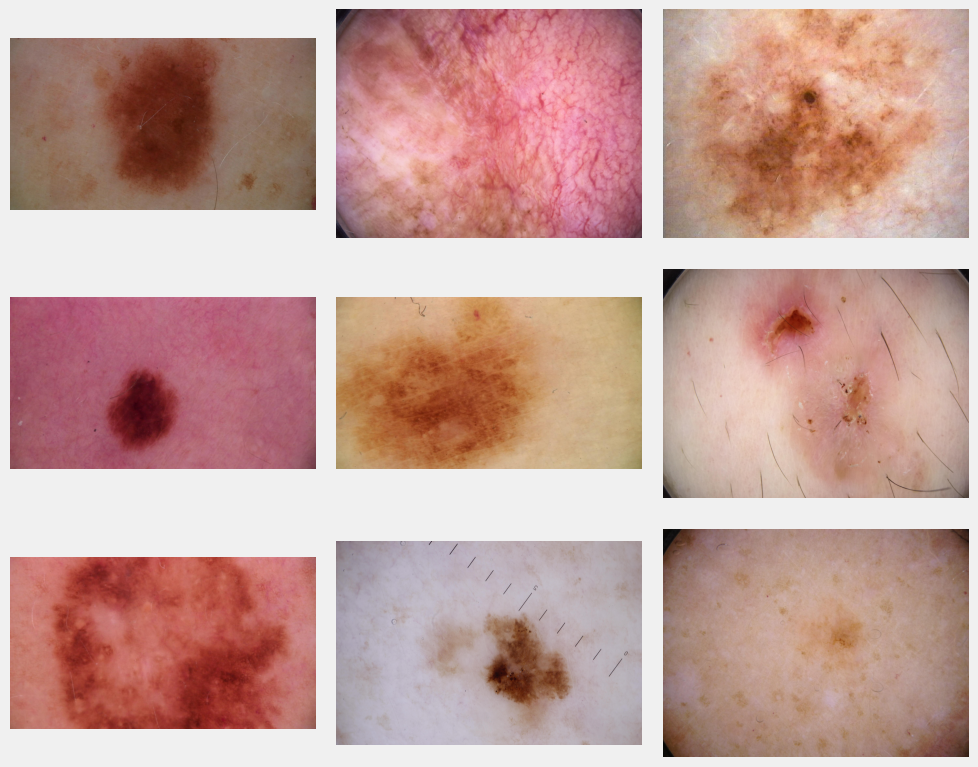

In [30]:
# Visualicemos algunas imágenes
images = train_df['image_name'].values

# Extraer 9 imagenes aleatorias
random_images = [np.random.choice(images+'.jpg') for i in range(9)]

# Dirección de las imágenes
img_dir = '/content/melanoma/sampled_train2'

print('Muestre imágnes aleatorias')

# Ajustar el tamaño de las imagenes
plt.figure(figsize=(10,8))

# Iterar y mostrar cada imagen
for i in range(9):
    plt.subplot(3, 3, i + 1)
    img = plt.imread(os.path.join(img_dir, random_images[i]))
    plt.imshow(img, cmap='gray')
    plt.axis('off')

# Adjuste de subplots
plt.tight_layout()

In [32]:
# Veamos algunos melanomas benignos y malignos
benign = train_df[train_df['benign_malignant']=='benign']
malignant = train_df[train_df['benign_malignant']=='malignant']

Muestra imágenes aleatorias benignas


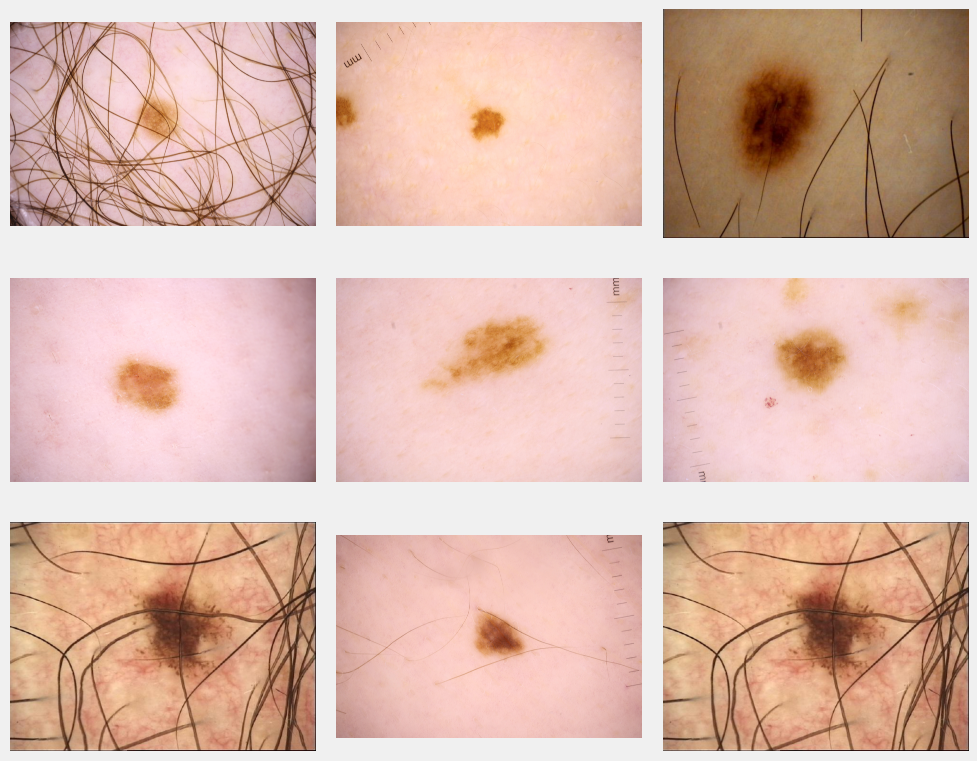

In [47]:
# Veamoslos benignos:
images = benign['image_name'].values

# Extraer 9 imagenes aleatorias
random_images = [np.random.choice(images+'.jpg') for i in range(9)]

# Dirección de las imágenes
img_dir = '/content/melanoma/sampled_train2'

print('Muestra imágenes aleatorias benignas')

# Ajustar el tamaño de las imagenes
plt.figure(figsize=(10,8))

# Iterar y mostrar cada imagen
for i in range(9):
    plt.subplot(3, 3, i + 1)
    img = plt.imread(os.path.join(img_dir, random_images[i]))
    plt.imshow(img, cmap='gray')
    plt.axis('off')

# Adjustar subplot
plt.tight_layout()

Muestra imágenes aleatorias malignas


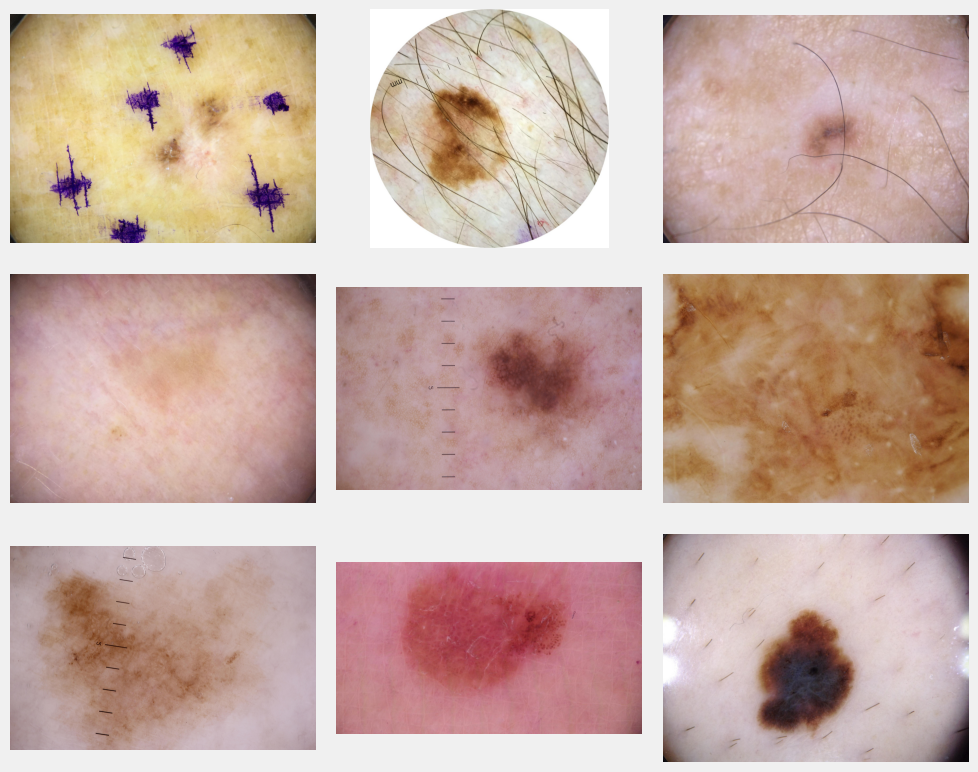

In [34]:
images = malignant['image_name'].values

# Extraer 9 imagenes aleatorias
random_images = [np.random.choice(images+'.jpg') for i in range(9)]

# Dirección de las imágenes
img_dir = '/content/melanoma/sampled_train2'

print('Muestra imágenes aleatorias malignas')

# Adjustar tamaño de las imagenes
plt.figure(figsize=(10,8))

# Iterar y mostrar las imágenes
for i in range(9):
    plt.subplot(3, 3, i + 1)
    img = plt.imread(os.path.join(img_dir, random_images[i]))
    plt.imshow(img, cmap='gray')
    plt.axis('off')

# Adjustar subplot
plt.tight_layout()

## Histogramas

Los histogramas son una representación gráfica que muestra con qué frecuencia ocurren varios valores de color en la imagen, es decir, la frecuencia de los valores de intensidad de los píxeles. En un espacio de color RGB, los valores de píxeles varían de 0 a 255, donde 0 representa el negro y 255 representa el blanco. El análisis de un histograma puede ayudarnos a comprender la distribución de brillo, contraste e intensidad de una imagen. Ahora veamos el histograma de una muestra seleccionada aleatoriamente de cada categoría.

### Categoría benigna:

Image dimensions:  (480, 640)
Maximum pixel value : 255.0 ; Minimum pixel value:0.0
Mean value of the pixels : 155.7 ; Standard deviation : 51.7


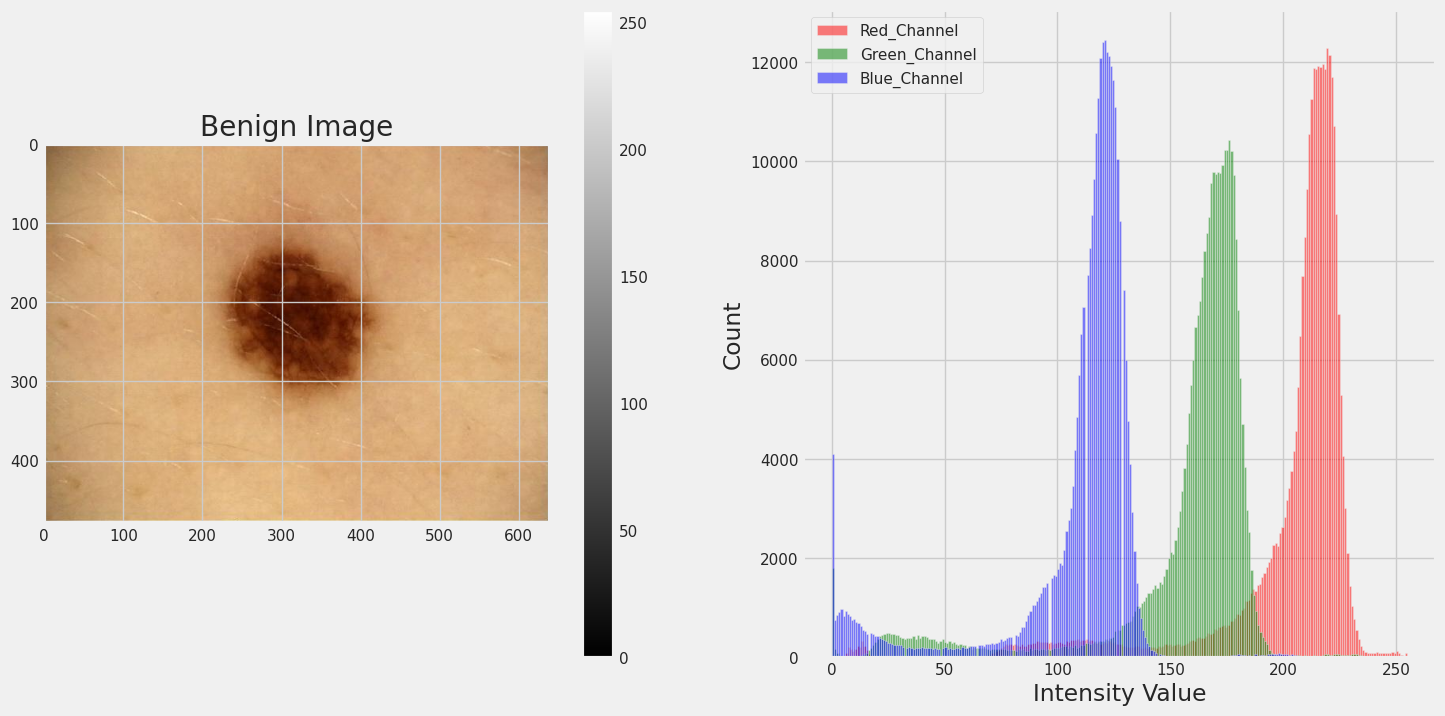

In [54]:
f = plt.figure(figsize=(16,8))
f.add_subplot(1,2, 1)

sample_img = benign['image_name'].values[0]+'.jpg'
raw_image = plt.imread(os.path.join(img_dir, sample_img))
plt.imshow(raw_image, cmap='gray')
plt.colorbar()
plt.title('Benign Image')
print(f"Image dimensions:  {raw_image.shape[0],raw_image.shape[1]}")
print(f"Maximum pixel value : {raw_image.max():.1f} ; Minimum pixel value:{raw_image.min():.1f}")
print(f"Mean value of the pixels : {raw_image.mean():.1f} ; Standard deviation : {raw_image.std():.1f}")

f.add_subplot(1,2, 2)

#_ = plt.hist(raw_image.ravel(),bins = 256, color = 'orange',)
_ = plt.hist(raw_image[:, :, 0].ravel(), bins = 256, color = 'red', alpha = 0.5)
_ = plt.hist(raw_image[:, :, 1].ravel(), bins = 256, color = 'Green', alpha = 0.5)
_ = plt.hist(raw_image[:, :, 2].ravel(), bins = 256, color = 'Blue', alpha = 0.5)
_ = plt.xlabel('Intensity Value')
_ = plt.ylabel('Count')
_ = plt.legend(['Red_Channel', 'Green_Channel', 'Blue_Channel'])
plt.show()

plt.show()

### Categoría maligna:

Image dimensions:  (4000, 6000)
Maximum pixel value : 255.0 ; Minimum pixel value:0.0
Mean value of the pixels : 174.9 ; Standard deviation : 36.8


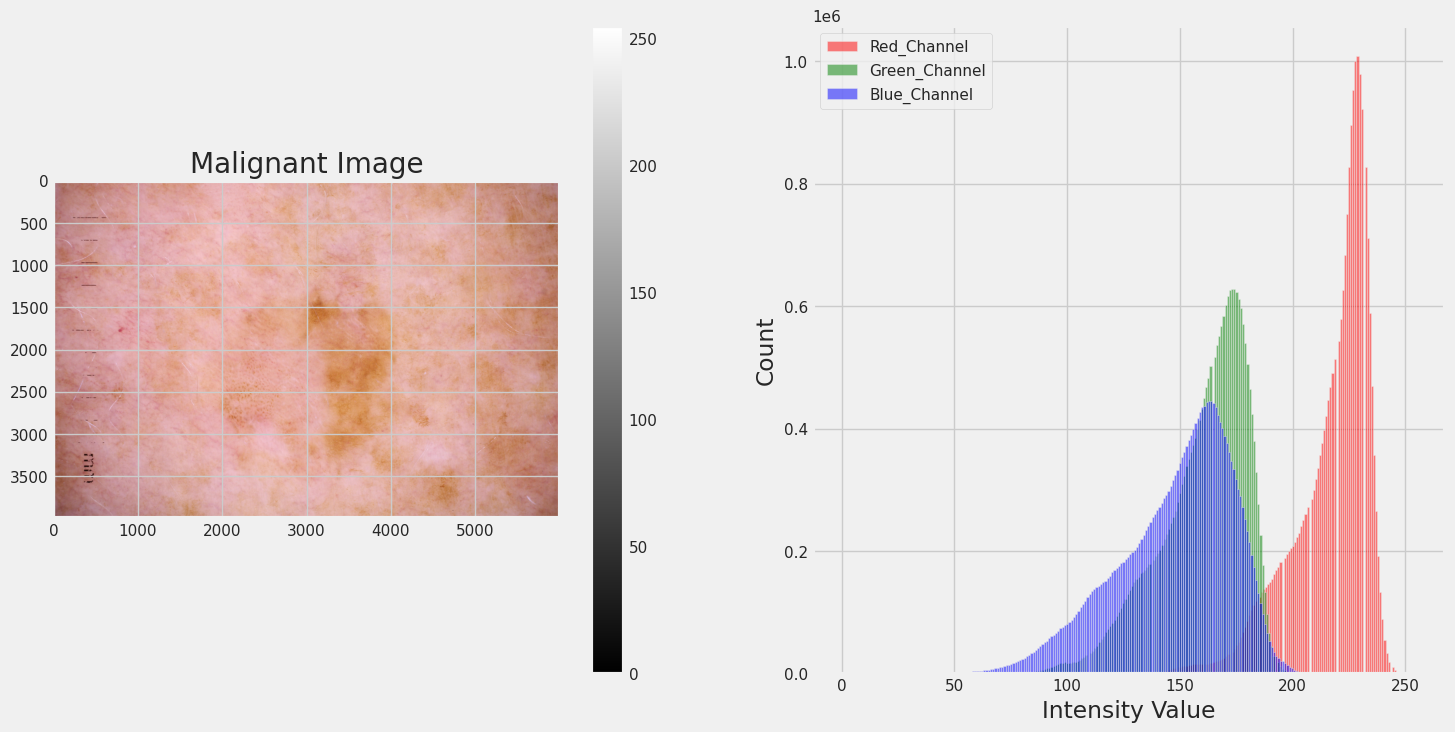

In [56]:
f = plt.figure(figsize=(16,8))
f.add_subplot(1,2, 1)

sample_img = malignant['image_name'].values[0]+'.jpg'
raw_image = plt.imread(os.path.join(img_dir, sample_img))
plt.imshow(raw_image, cmap='gray')
plt.colorbar()
plt.title('Malignant Image')
print(f"Image dimensions:  {raw_image.shape[0],raw_image.shape[1]}")
print(f"Maximum pixel value : {raw_image.max():.1f} ; Minimum pixel value:{raw_image.min():.1f}")
print(f"Mean value of the pixels : {raw_image.mean():.1f} ; Standard deviation : {raw_image.std():.1f}")

f.add_subplot(1,2, 2)

#_ = plt.hist(raw_image.ravel(),bins = 256, color = 'orange',)
_ = plt.hist(raw_image[:, :, 0].ravel(), bins = 256, color = 'red', alpha = 0.5)
_ = plt.hist(raw_image[:, :, 1].ravel(), bins = 256, color = 'Green', alpha = 0.5)
_ = plt.hist(raw_image[:, :, 2].ravel(), bins = 256, color = 'Blue', alpha = 0.5)
_ = plt.xlabel('Intensity Value')
_ = plt.ylabel('Count')
_ = plt.legend(['Red_Channel', 'Green_Channel', 'Blue_Channel'])
plt.show()

In [39]:
# Leer el dataset de Pandas
test_df = pd.read_csv("/content/melanoma/sampled_test2.csv")

In [40]:
test_df['target'].value_counts()

target
0    50
1    50
Name: count, dtype: int64

# Creación del modelo:

Primero, necesitamos preparar los datos para que sean consumidos por el modelo

In [57]:
## Creación array para imágenes y labels de entrenamiento
import os
import cv2
import numpy as np

#Resize images
SIZE = 256

# Ruta de la carpeta con las imágenes
IMAGE_PATH_TRAIN = "/content/melanoma/sampled_train2"

# Inicializar arrays vacíos
train_images = []
train_labels = []

# Recorrer cada fila del DataFrame
for i in range(len(train_df)):
  # Obtener el nombre de la imagen
  image_name = train_df.loc[i, "image_name"] + ".jpg"

  # Obtener la etiqueta
  label = train_df.loc[i, "target"]

  # Ruta completa de la imagen
  img_path = os.path.join(IMAGE_PATH_TRAIN, image_name)

  # Leer la imagen con OpenCV
  img = cv2.imread(img_path, cv2.IMREAD_COLOR)
  img = cv2.resize(img, (SIZE, SIZE))
  img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

  # Agregar la imagen al array
  train_images.append(img)

  # Agregar la etiqueta al array
  train_labels.append(label)

# Imprimir la longitud de los arrays para verificar
print(f"Longitud de train_images: {len(train_images)}")
print(f"Longitud de train_labels: {len(train_labels)}")

#Convert lists to arrays
train_images = np.array(train_images)
train_labels = np.array(train_labels)

Longitud de train_images: 500
Longitud de train_labels: 500


In [58]:
# Ruta de la carpeta con las imágenes
IMAGE_PATH_TEST = "/content/melanoma/sampled_test2"

# Capture test/validation data and labels into respective lists

test_images = []
test_labels = []

# Recorrer cada fila del DataFrame
for i in range(len(test_df)):
  # Obtener el nombre de la imagen
  image_name = test_df.loc[i, "image_name"] + ".jpg"

  # Obtener la etiqueta
  label = test_df.loc[i, "target"]

  # Ruta completa de la imagen
  img_path = os.path.join(IMAGE_PATH_TEST, image_name)

  # Leer la imagen con OpenCV
  img = cv2.imread(img_path, cv2.IMREAD_COLOR)
  img = cv2.resize(img, (SIZE, SIZE))
  img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

  # Agregar la imagen al array
  test_images.append(img)

  # Agregar la etiqueta al array
  test_labels.append(label)

# Imprimir la longitud de los arrays para verificar
print(f"Longitud de test_images: {len(test_images)}")
print(f"Longitud de test_labels: {len(test_labels)}")

#Convert lists to arrays
test_images = np.array(test_images)
test_labels = np.array(test_labels)

Longitud de test_images: 100
Longitud de test_labels: 100


In [59]:
train_images

array([[[[166, 111, 114],
         [166, 116, 117],
         [168, 116, 118],
         ...,
         [172, 124, 122],
         [172, 119, 113],
         [170, 122, 118]],

        [[168, 113, 118],
         [168, 113, 118],
         [168, 113, 118],
         ...,
         [173, 121, 125],
         [170, 116, 116],
         [166, 121, 118]],

        [[162, 110, 114],
         [169, 116, 122],
         [166, 114, 116],
         ...,
         [174, 125, 128],
         [172, 120, 122],
         [169, 118, 117]],

        ...,

        [[126,  81,  88],
         [129,  80,  84],
         [137,  91,  93],
         ...,
         [151,  99,  85],
         [152, 100,  87],
         [151,  99,  78]],

        [[129,  87,  90],
         [130,  77,  83],
         [137,  91,  93],
         ...,
         [151,  95,  82],
         [149,  91,  79],
         [150,  99,  82]],

        [[126,  77,  87],
         [123,  75,  75],
         [128,  83,  84],
         ...,
         [148,  92,  77],
        

In [60]:
train_labels

array([1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0,
       0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0,
       1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0,
       0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0,
       0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1,
       0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0,
       0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0,
       1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0,
       0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0,
       1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0,

In [61]:
#Split data into test and train datasets (already split but assigning to meaningful convention)
x_train, y_train, x_test, y_test = train_images, train_labels, test_images, test_labels

In [62]:
# Normalize pixel values to between 0 and 1
x_train, x_test = x_train / 255.0, x_test / 255.0

In [63]:
from keras.models import Model, Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
#from keras.layers.normalization import BatchNormalization
from tensorflow.keras.layers import BatchNormalization
import os
import seaborn as sns
from keras.applications.vgg16 import VGG16

### ¿Cómo funciona este modelo?

Para poder clasificar las imágenes de melanoma necesitamos hacer dos pasos:


1.   Extraer características de las imágenes.
2.   Enseñar a la máquina a distinguir esas características para poder predecir.

El paso 1. se realiza usando una red VGG (Visual Geometry Group) pre entrenada, estas redes son un tipo de red neuronal convolucional (CNN) que se utilizan para extraer características de imágenes. La arquitectura de VGG se basa en una serie de capas convolucionales apiladas, seguidas de capas de pooling y capas totalmente conectadas.

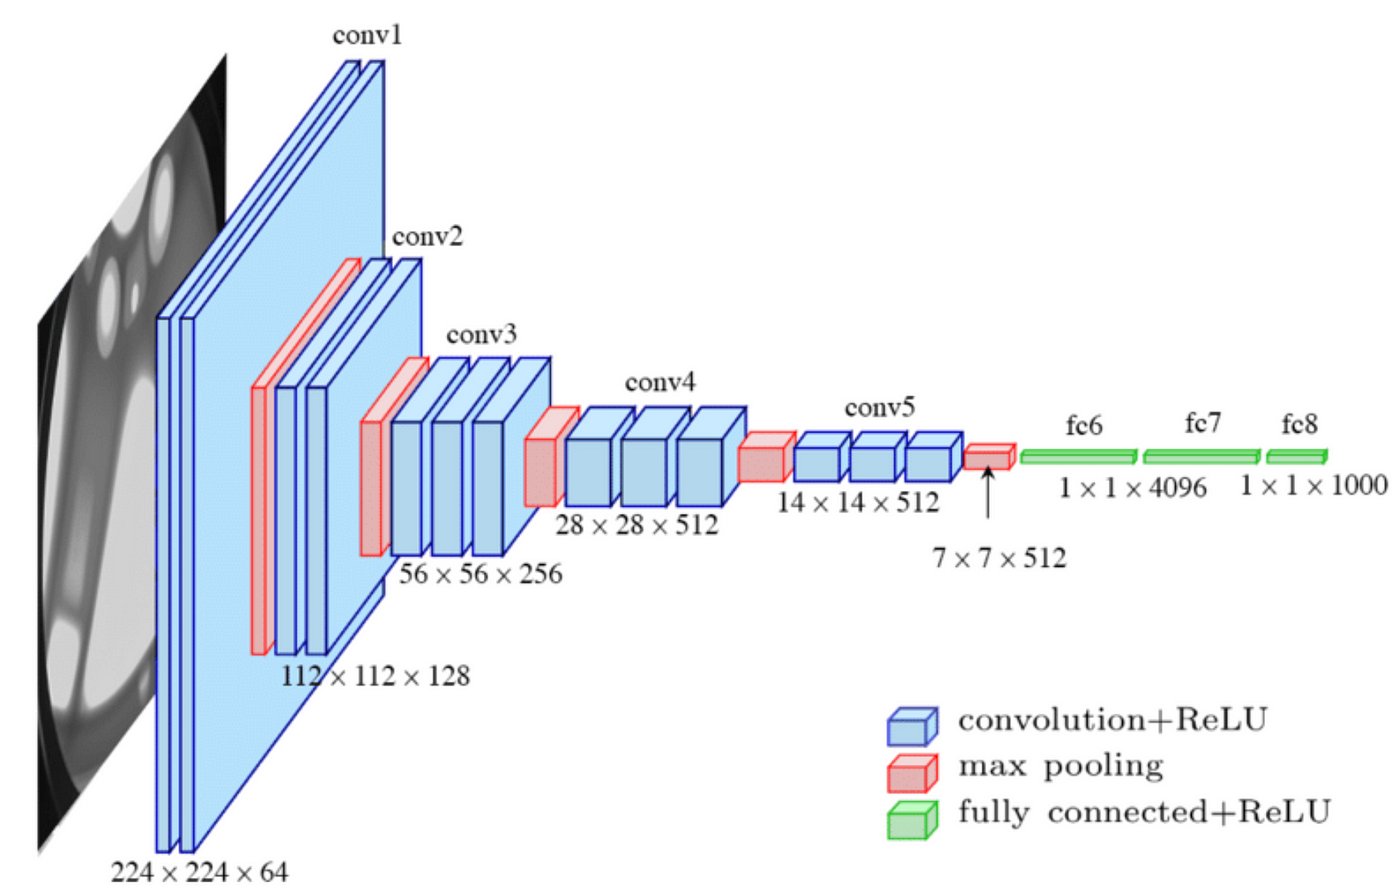

**Proceso de extracción de features:**

*   **Convolución:** Las capas convolucionales aplican filtros a la imagen para detectar patrones específicos. Los filtros se deslizan por la imagen, extrayendo features de diferentes regiones.
*   **Pooling:** Las capas de pooling reducen la dimensionalidad de la imagen, combinando valores vecinos y descartando información redundante.
*   **Capas totalmente conectadas:** Las capas totalmente conectadas clasifican la imagen en función de las features extraídas por las capas convolucionales.






In [64]:
#Load model wothout classifier/fully connected layers
VGG_model = VGG16(weights='imagenet', include_top=False, input_shape=(SIZE, SIZE, 3))

58889256/58889256 [==============================] - 3s 0us/step


In [65]:
#Make loaded layers as non-trainable. This is important as we want to work with pre-trained weights
for layer in VGG_model.layers:
	layer.trainable = False

In [66]:
VGG_model.summary()  #Trainable parameters will be 0

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

In [67]:
#Now, let us use features from convolutional network for RF
feature_extractor=VGG_model.predict(x_train)

16/16 [==============================] - 368s 23s/step


In [68]:
features = feature_extractor.reshape(feature_extractor.shape[0], -1)

Una vez se hizo la extracción de características, usaremos un modelo XGBoost ("extreme gradient boosting") para la clasificacion de las imágenes.

**¿Qué es el XGBoost y cómo funciona?**

XGBoost es un algoritmo de aprendizaje automático de tipo "gradiente boosting" que se utiliza para la clasificación de imágenes, entre otras tareas. A continuación se explica cómo funciona:

1.  Entrenamiento del modelo:

*   **Conjunto de datos:** Se requiere un conjunto de datos con imágenes etiquetadas para entrenar el modelo.
*   **Árbol de decisión:** XGBoost utiliza árboles de decisión como base para el aprendizaje. Se crea un conjunto de árboles débiles, cada uno con sus propias reglas de decisión.
*   **Boosting:** Los árboles se combinan de forma secuencial, con el objetivo de mejorar la precisión general del modelo. Se pondera la importancia de cada árbol en la predicción final.


2.  Clasificación de imágenes:

*   **Extracción de features:** Las imágenes se procesan para extraer características relevantes para la clasificación.
*   **Predicción:** Las características se pasan a través del conjunto de árboles entrenados. Cada árbol hace una predicción, y la predicción final se calcula como la suma ponderada de las predicciones de los árboles.


In [69]:
#This is our X input to XGBoost
X_for_training = features

In [70]:
#XGBOOST
import xgboost as xgb
model = xgb.XGBClassifier()
model.fit(X_for_training, y_train) #For sklearn no one hot encoding

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [71]:
#Send test data through same feature extractor process
X_test_feature = VGG_model.predict(x_test)
X_test_features = X_test_feature.reshape(X_test_feature.shape[0], -1)

4/4 [==============================] - 66s 15s/step


In [72]:
#Now predict using the trained RF model.
prediction = model.predict(X_test_features)

In [73]:
#Print overall accuracy
from sklearn import metrics
print ("Accuracy = ", metrics.accuracy_score(test_labels, prediction))

Accuracy =  0.81


<Axes: >

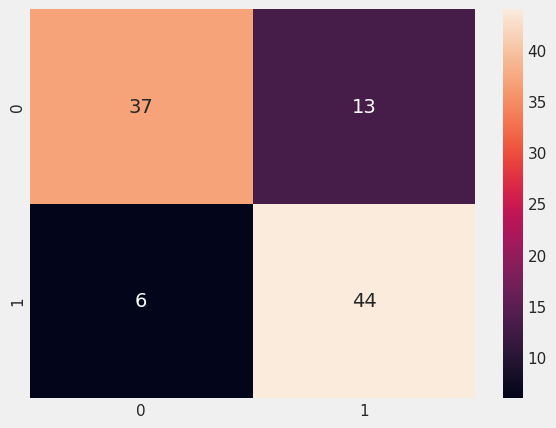

In [74]:
#Confusion Matrix - verify accuracy of each class
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test_labels, prediction)
#print(cm)
sns.heatmap(cm, annot=True)

In [77]:
pip install -U seaborn-image

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 332.3/332.3 kB 8.6 MB/s eta 0:00:00


1/1 [==============================] - 1s 869ms/step
The prediction for this image is:  1
The actual label for this image is:  1


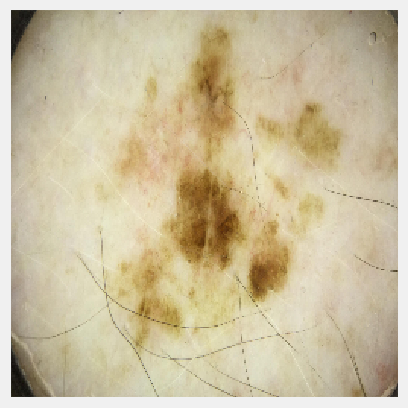

In [78]:
#Check results on a few select images
import seaborn_image as isns

n=np.random.randint(0, x_test.shape[0])
img = x_test[n]
isns.imshow(img)
input_img = np.expand_dims(img, axis=0) #Expand dims so the input is (num images, x, y, c)
input_img_feature=VGG_model.predict(input_img)
input_img_features=input_img_feature.reshape(input_img_feature.shape[0], -1)
prediction = model.predict(input_img_features)[0]
# prediction = le.inverse_transform([prediction])  #Reverse the label encoder to original name
print("The prediction for this image is: ", prediction)
print("The actual label for this image is: ", test_labels[n])